# EDA Notebook

## Notes

### Sensor behavior
- s2, s3, s4, s7, s11, s12, s13, s14 appear to trend downward as cycle increases
- s1, s5 look relatively flat → likely not useful
- s17 appears noisy

### Engine-to-engine variation
- Engine baselines differ for s3 and s11
- Some units degrade faster than others

### Missing/noisy data
- No obvious missing values
- Some sensors appear constant → may drop later

### RUL thinking
- RUL decreases linearly with cycle
- Failure always at final row per engine in training


In [6]:
import sys, os
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root not in sys.path:
    sys.path.append(root)
print("Project root:", root)


Project root: /Users/jpcourneya/Documents/Projects/predictive-maintenance-cmapss


In [7]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils.cmapss import (
    load_fd_raw, describe_fd, make_train_rul_labels, sequence_length_stats
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Matplotlib is building the font cache; this may take a moment.


In [14]:
from pathlib import Path
import sys, os

# Make src/ importable
root = Path.cwd().parent
if str(root) not in sys.path:
    sys.path.append(str(root))

from src.utils.cmapss import load_fd_raw, sequence_length_stats

# Point base_dir to the actual raw folder from the project root
base_dir = str(root / "data" / "raw")
print("Using base_dir:", base_dir)

fd = load_fd_raw(fd="FD001", base_dir=base_dir, verbose=True)
train_raw, test_raw, rul_test = fd.train, fd.test, fd.rul_test

print("Train head:")
display(train_raw.head())
print("Per-engine life stats (train):")
display(sequence_length_stats(train_raw))



Using base_dir: /Users/jpcourneya/Documents/Projects/predictive-maintenance-cmapss/data/raw
Dataset FD001: 1 condition(s), 1 fault mode(s) — HPC degradation
  Train shape: (20631, 26)  | engines: 100
  Test  shape: (13096, 26)  | engines: 100
  RUL_test length: 100
Train head:


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Per-engine life stats (train):


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: cycle, dtype: float64

In [15]:
from src.utils.cmapss import sequence_length_stats

print("Train shape:", train_raw.shape, " | Test shape:", test_raw.shape, " | RUL_test:", len(rul_test))
print("\nColumns:\n", list(train_raw.columns))

print("\nPer-engine life stats (train):")
display(sequence_length_stats(train_raw))


Train shape: (20631, 26)  | Test shape: (13096, 26)  | RUL_test: 100

Columns:
 ['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

Per-engine life stats (train):


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: cycle, dtype: float64

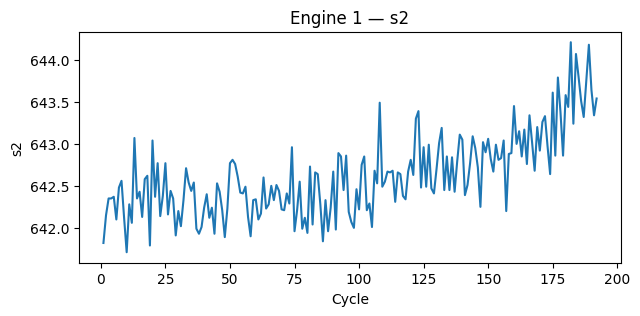

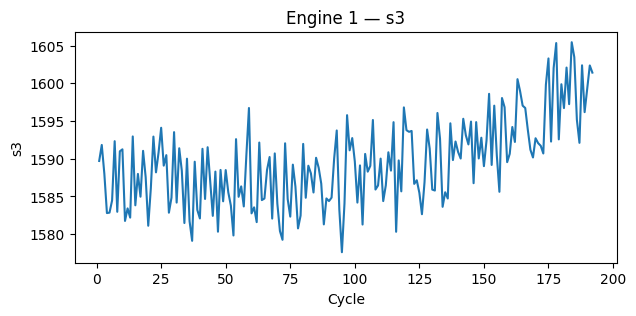

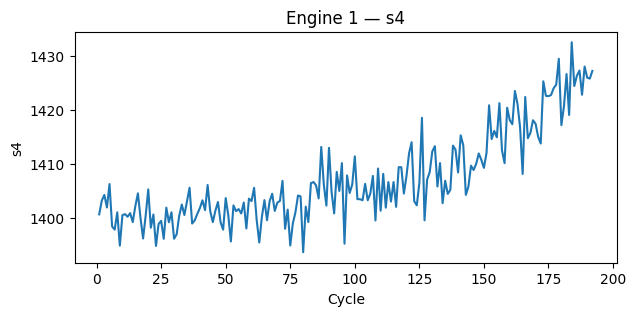

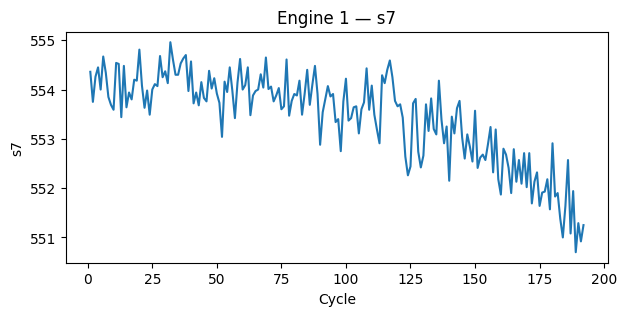

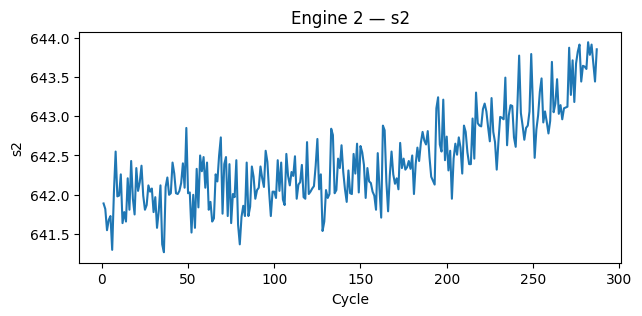

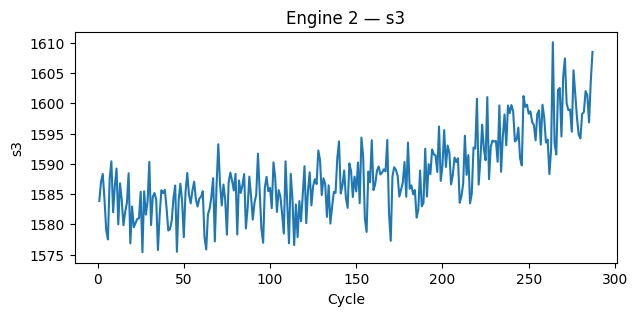

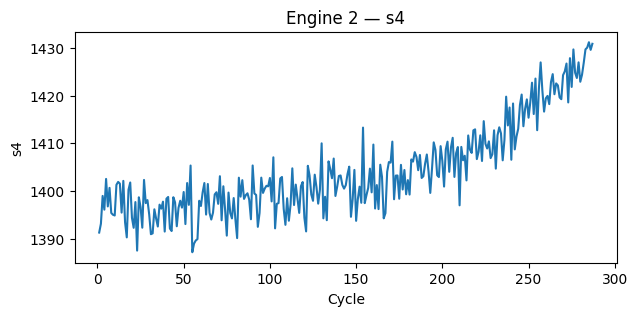

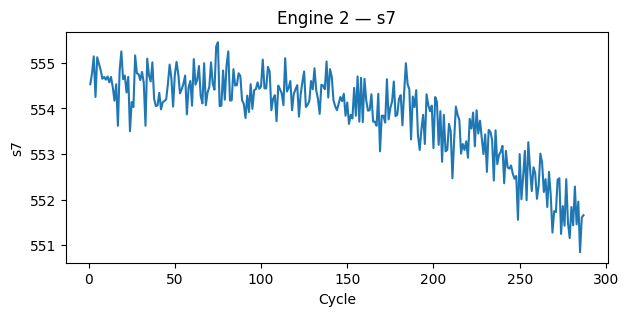

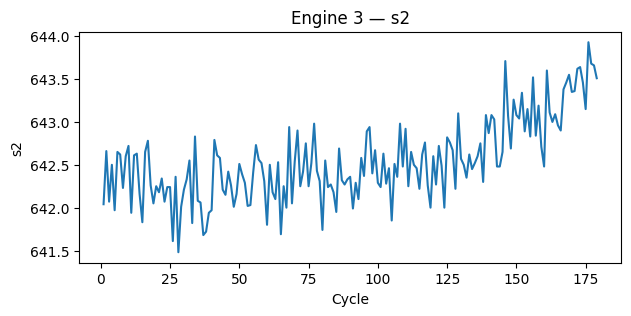

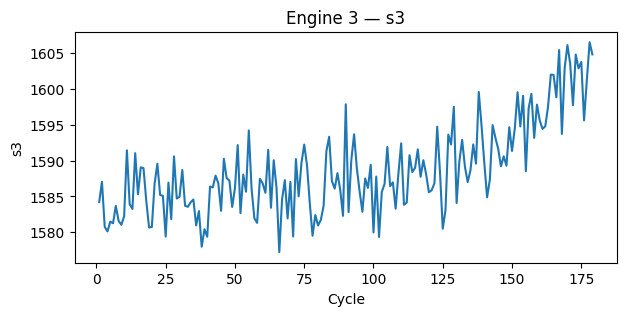

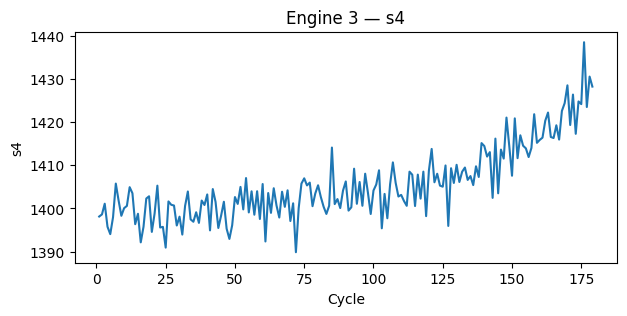

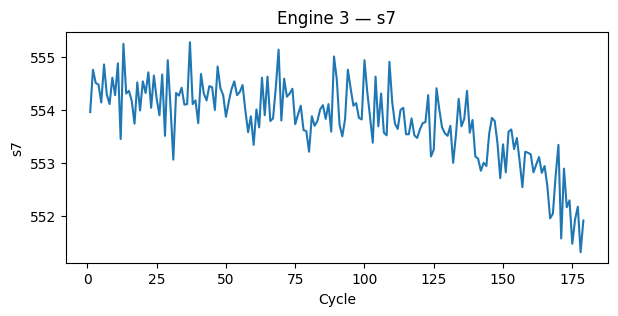

In [16]:
import matplotlib.pyplot as plt
import numpy as np

example_engines = train_raw["engine_id"].unique()[:3]  # first 3 engines
sensors = ["s2","s3","s4","s7","s11","s12","s13","s14"]

for eng in example_engines:
    df_e = train_raw[train_raw.engine_id == eng]
    for s in sensors[:4]:  # start light
        plt.figure(figsize=(7,3))
        plt.plot(df_e["cycle"], df_e[s])
        plt.title(f"Engine {eng} — {s}")
        plt.xlabel("Cycle"); plt.ylabel(s)
        plt.show()


In [17]:
num_cols = [c for c in train_raw.columns if c.startswith("s")] + ["cycle"]
corr_cycle = train_raw[num_cols].corr(numeric_only=True)["cycle"].sort_values(ascending=False)

print("Top sensors positively correlated with cycle (often ↑ with wear):")
display(corr_cycle.head(12))
print("\nMost negative (may ↓ with wear):")
display(corr_cycle.tail(12))


Top sensors positively correlated with cycle (often ↑ with wear):


cycle    1.000000
s11      0.634385
s4       0.624577
s15      0.588676
s17      0.566995
s2       0.549898
s3       0.543947
s13      0.477523
s8       0.475977
s9       0.443999
s14      0.370324
s6       0.105980
Name: cycle, dtype: float64


Most negative (may ↓ with wear):


s14    0.370324
s6     0.105980
s20   -0.583597
s21   -0.585923
s7    -0.595914
s12   -0.611354
s1          NaN
s5          NaN
s10         NaN
s16         NaN
s18         NaN
s19         NaN
Name: cycle, dtype: float64

In [18]:
from src.utils.cmapss import make_train_rul_labels

train_labeled = make_train_rul_labels(train_raw)

num_cols_rul = [c for c in train_labeled.columns if c.startswith("s")] + ["RUL"]
corr_rul = train_labeled[num_cols_rul].corr(numeric_only=True)["RUL"].sort_values()  # most negative first

print("Most negative correlation with RUL (strong signal = lower RUL):")
display(corr_rul.head(12))

Most negative correlation with RUL (strong signal = lower RUL):


s11   -0.696228
s4    -0.678948
s15   -0.642667
s2    -0.606484
s17   -0.606154
s3    -0.584520
s8    -0.563968
s13   -0.562569
s9    -0.390102
s14   -0.306769
s6    -0.128348
s20    0.629428
Name: RUL, dtype: float64

In [19]:
sensor_cols = [c for c in train_raw.columns if c.startswith("s")]
variances = train_raw[sensor_cols].var().sort_values()
print("Lowest-variance sensors (candidates to drop):")
display(variances.head(10))


Lowest-variance sensors (candidates to drop):


s1     0.000000e+00
s19    0.000000e+00
s18    0.000000e+00
s10    0.000000e+00
s16    1.926023e-34
s5     3.155597e-30
s6     1.929279e-06
s15    1.406628e-03
s8     5.038938e-03
s13    5.172330e-03
dtype: float64

## Notes — FD001
**Sensor behavior:**  
- Trends with cycle (likely useful): …  
- Flat/noisy (consider drop): …  

**Engine-to-engine variation:**  
- Baselines differ in …  
- Operating settings spread: …  

**RUL sanity:**  
- RUL = max(cycle) − cycle hits 0 at last cycle per engine (verified/yes/no).  

**Takeaways for Step-2:**  
- Keep sensors: s2,s3,s4,s7,s11,s12,s13,s14 (adjust from your findings)  
- Drop sensors: …  
- Scaling plan: global (single condition)  
